In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('../data/AB_NYC_2019.csv')

In [3]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
df.shape

(48895, 16)

In [5]:
from math import sin, cos, sqrt, atan2, radians

# compute the distance in km between two coordinates
def compute_globe_distance(lat1, lon1, lat2, lon2):
    
    # approximate radius of earth in km
    R = 6373.0

    # transforming in radians
    lat1_r = radians(lat1)
    lon1_r = radians(lon1)
    lat2_r = radians(lat2)
    lon2_r = radians(lon2)

    # differences in coordinates
    dlon = lon2_r - lon1_r
    dlat = lat2_r - lat1_r
    
    # haversine
    a = sin(dlat / 2)**2 + cos(lat1_r) * cos(lat2_r) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    return distance

In [6]:
df_coord = df[['latitude', 'longitude']]

In [30]:
df_coord_red = df_coord.head(1000)

In [34]:
from scipy.spatial.distance import squareform, pdist
from geopy.distance import geodesic

df_dist = pd.DataFrame(squareform(pdist(df_coord_red.iloc[:, 1:])), columns=df_coord_red.index, index=df_coord_red.index)

In [33]:
df_dist.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.00000,0.01140,0.03047,0.01261,0.02838,0.00263,0.01641,0.01256,0.00514,0.01800,...,0.01759,0.04292,0.01000,0.02161,0.01433,0.01410,0.02384,0.01819,0.00729,0.00753
1,0.01140,0.00000,0.04187,0.02401,0.03978,0.00877,0.02781,0.00116,0.01654,0.00660,...,0.00619,0.05432,0.02140,0.01021,0.02573,0.02550,0.03524,0.00679,0.00411,0.01893
2,0.03047,0.04187,0.00000,0.01786,0.00209,0.03310,0.01406,0.04303,0.02533,0.04847,...,0.04806,0.01245,0.02047,0.05208,0.01614,0.01637,0.00663,0.04866,0.03776,0.02294
3,0.01261,0.02401,0.01786,0.00000,0.01577,0.01524,0.00380,0.02517,0.00747,0.03061,...,0.03020,0.03031,0.00261,0.03422,0.00172,0.00149,0.01123,0.03080,0.01990,0.00508
4,0.02838,0.03978,0.00209,0.01577,0.00000,0.03101,0.01197,0.04094,0.02324,0.04638,...,0.04597,0.01454,0.01838,0.04999,0.01405,0.01428,0.00454,0.04657,0.03567,0.02085


In [10]:
epsilon = 0.001
def sparsify(x):
    if x > epsilon:
        return 0
    return x

In [11]:
df_dist_s = df_dist.applymap(sparsify)
print('there are {i} non-zero entries'.format(i = df_dist_s.astype(bool).sum().sum()))

there are 24796 non-zero entries


In [14]:
df_dist_s

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0000,0.0,0.0,0.0,0.00023,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00019,...,0.0006,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0


In [19]:
adj = df_dist_s.values

In [21]:
adj

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
import networkx as nx
G=nx.from_numpy_matrix(adj)

In [23]:
G.size()

12398

In [24]:
df_coord_red

,latitude,longitude
0,40.64749,-73.97237
1,40.75362,-73.98377
2,40.80902,-73.94190
3,40.68514,-73.95976
4,40.79851,-73.94399
...,...,...
995,40.80192,-73.95827
996,40.79314,-73.94853
997,40.74530,-73.99056
998,40.72812,-73.97966


In [25]:
df_coord_red['coord'] = df.apply(lambda row: [row['latitude'],row['longitude']], axis=1)
df_coord_red.head()

/Users/sylvainlugeon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,latitude,longitude,coord
0,40.64749,-73.97237,"[40.647490000000005, -73.97237]"
1,40.75362,-73.98377,"[40.75362, -73.98376999999999]"
2,40.80902,-73.94190,"[40.809020000000004, -73.9419]"
3,40.68514,-73.95976,"[40.685140000000004, -73.95976]"
4,40.79851,-73.94399,"[40.79851, -73.94399]"


In [26]:
# create dictionnary for nodes positions
coord_dict = df_coord_red.coord.to_dict()

/Users/sylvainlugeon/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


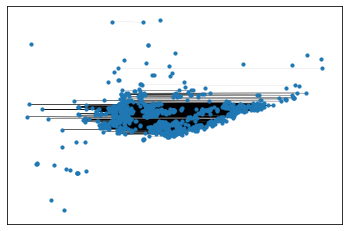

In [27]:
nx.draw_networkx(G, pos=coord_dict, with_labels=False, node_size=10, width=0.05)